# Sentiment Classification

- 런타임 -> 런타임 유형변경 -> GPU로 설정!



In [1]:
# check runtime type
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
  device = 'cpu'
else:
  print(gpu_info)
  device = 'cuda'

Thu Oct 29 04:28:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 영화 리뷰 데이터 불러오기

In [1]:
import pandas as pd
# from konlpy.tag import Mecab

In [2]:
path = '/content/drive/My Drive/Colab Notebooks/2020-PoscoICT/Data/'

In [4]:
train_df = pd.read_csv(path+'nsmc/ratings_train.txt', sep='\t', encoding='utf-8')
test_df = pd.read_csv(path+'nsmc/ratings_test.txt', sep='\t', encoding='utf-8')
print(train_df.shape, test_df.shape)

# 리뷰 또는 레이블이 비어있는 경우 제거
train_df.dropna(how='any', inplace=True)
test_df.dropna(how='any', inplace=True)
print(train_df.shape, test_df.shape)

# 주의: CNN은 문장의 토큰 갯수(또는 문장 길이)에 따라 CNN학습이 안될 수 있다. (filter size를 적용할 수 없게된다)
train_df['num_tokens'] = train_df['document'].apply(lambda x: len(x.split(' ')))
test_df['num_tokens'] = test_df['document'].apply(lambda x: len(x.split(' ')))

train_df = train_df[train_df.num_tokens > 6]
test_df = test_df[test_df.num_tokens > 6]

train_df = train_df.drop(['num_tokens'], axis=1)
test_df = test_df.drop(['num_tokens'], axis=1)
print(train_df.shape, test_df.shape)

train_df.to_csv(path+'nsmc/ratings_train_cleaned.tsv', sep='\t', index=False, encoding='utf-8')
test_df.to_csv(path+'nsmc/ratings_test_cleaned.tsv', sep='\t', index=False, encoding='utf-8')

(150000, 3) (50000, 3)
(149995, 3) (49997, 3)
(65024, 3) (21566, 3)


### TorchText 로 네이버 영화 리뷰 데이터 로드하기

- 텍스트 분류 문제를 풀 때, 유용하게 사용되는 torchtext라는 라이브러리
- 다양한 기능을 제공하고 있으며, documentation도 함께 참고(https://pytorch.org/text/#)
- 참고자료: http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/

In [5]:
import torch
from torchtext.data import TabularDataset
from torchtext import data
import random

In [6]:
# 필드 정의하기(전처리 방식 지정)
TEXT = data.Field(# tokenize=Mecab().morphs,	# 토크나이저로는 Mecab 사용.
                  tokenize = lambda x: x.split(),
                  batch_first = True)
                  # sequential=True,
                  # use_vocab=True, 					# 단어집합을 만든다
                  # lower=True,
                  # batch_first=True,
                  # fix_length=20) 						# 패딩 길이는 20

LABEL = data.LabelField(dtype = torch.float)
# LABEL = data.Field(sequential=False,
#                    use_vocab=False,
#                    is_target=True)


# 네이버 영화리뷰 데이터는 [리뷰아이디, 리뷰, 라벨] 세가지로 이뤄져있기 때문
# ID = data.Field(sequential=False, use_vocab=False,)
                   
# 데이터셋 제작하기(전처리 수행)
train_data, test_data = TabularDataset.splits(
        path='.', train=path+'nsmc/ratings_train_cleaned.tsv', test=path+'nsmc/ratings_test_cleaned.tsv', format='tsv',
        fields=[('id', None), ('text', TEXT), ('label', LABEL)], skip_header=True)

print('훈련 샘플의 개수 : {}'.format(len(train_data)))
print('테스트 샘플의 개수 : {}'.format(len(test_data)))
print('훈련 데이터 예제 : {}'.format(vars(train_data[0])))

훈련 샘플의 개수 : 65024
테스트 샘플의 개수 : 21566
훈련 데이터 예제 : {'text': ['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화!스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다'], 'label': '1'}


In [7]:
train_data, valid_data = train_data.split(random_state=random.seed(1234))

In [8]:
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

print("Size of TEXT vocabulary:",len(TEXT.vocab))
print("Size of LABEL vocabulary:",len(LABEL.vocab))

Size of TEXT vocabulary: 25002
Size of LABEL vocabulary: 2


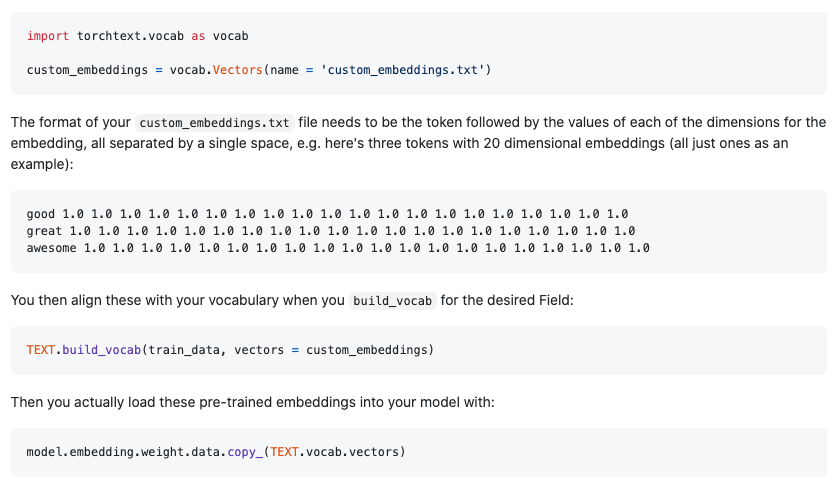

In [ ]:
# import torchtext.vocab as vocab
# custom_embeddings = vocab.Vectors(name = path+'w2v_embeddings.txt')
# TEXT.build_vocab(train_data, vectors=custom_embeddings, max_size=25000)
# LABEL.build_vocab(train_data)

# print("Size of TEXT vocabulary:",len(TEXT.vocab))
# print("Size of LABEL vocabulary:",len(LABEL.vocab))

In [9]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Buckets sequences of similar lengths together
# Text Classification, Sequence tagging에 주로 사용
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=False,
    device = device)

cuda


## CNN

- 커널의 column사이즈를 임베딩 차원에 맞추어, 단어 벡터를 n-gram 형태로 convolution
- pre-trained embedding vector를 사용할 때 더 좋은 성능을 나타낸다고 한다
- 참고 논문 : [Yoon Kim, 2014, Convolutional Neural Networks for Sentence Classification](https://www.aclweb.org/anthology/D14-1181/)

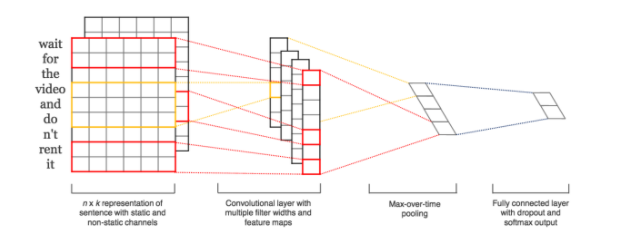

### Model Architecture

- [nn.ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html): PyTorch의 nn.Modules를 list형태로 사용할 수 있다. 
- 논문에서는 3개의 filter size(3,4,5)만 사용했으나, 좀 더 general 하게 사용하도록 만든 구조이다.
- convolutional layer를 list of filter size를 활용하여 dynamic하게 만들 수 있다

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        super().__init__()
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text = text.permute(1, 0)       # [batch size, sent len]
        embedded = self.embedding(text)   # embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)  # embedded = [batch size, 1, sent len, emb dim]

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]         # conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  # pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))        # cat = [batch size, n_filters * len(filter_sizes)]
  
        return self.fc(cat)

- Conv1d로 위의 CNN 구조를 구현 가능
- Conv1d일 때, embedding dimension은 depth of filter, number of tokens는 width가 된다

In [12]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(
            INPUT_DIM,
            EMBEDDING_DIM,
            N_FILTERS,
            FILTER_SIZES,
            OUTPUT_DIM,
            DROPOUT,
            PAD_IDX
          )

model

CNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### Train Model

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,620,801 trainable parameters


### If pre-trained embeddings exist

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

# initialize zero weights for unknown and padding tokens
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [14]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [15]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [16]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() # convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
# 학습 중간 batch별 accuracy를 측정하기 위한 helper function
def categorical_accuracy(preds, y):

    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    
    return correct.sum().detach().cpu().numpy() / y.shape[0]

In [17]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:        
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path+'cnn-model.pt')
    
    print(f'Epoch [{epoch + 1}/{N_EPOCHS}]: Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f}, Val. Acc: {valid_acc*100:.2f}%')

Epoch [1/5]: Train Loss: 0.626, Train Acc: 63.80% | Val. Loss: 0.552, Val. Acc: 71.05%
Epoch [2/5]: Train Loss: 0.476, Train Acc: 76.74% | Val. Loss: 0.496, Val. Acc: 75.37%
Epoch [3/5]: Train Loss: 0.376, Train Acc: 83.00% | Val. Loss: 0.488, Val. Acc: 76.72%
Epoch [4/5]: Train Loss: 0.305, Train Acc: 86.62% | Val. Loss: 0.495, Val. Acc: 77.55%
Epoch [5/5]: Train Loss: 0.246, Train Acc: 89.71% | Val. Loss: 0.527, Val. Acc: 77.75%


In [21]:
model.load_state_dict(torch.load(path+'cnn-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.488 | Test Acc: 76.57%


In [22]:
def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = sentence.split(' ')
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [23]:
predict_sentiment(model, "영화 너무 재미없다!")

0.4958924651145935